In [1]:
# Importing necessary libraries
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

import warnings

warnings.filterwarnings('ignore')

In [2]:
# Decoding the data 
data = r"D:\LuxDev\World-bank\API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_59.csv"  # Use raw string (r"") to avoid escape issues

with open(data, "r", newline="", encoding="utf-8") as csv_file, open("output.txt", "w", encoding="utf-8") as text_file:
    reader = csv.reader(csv_file)
    for row in reader:
        text_file.write(", ".join(row) + "\n")  # Write each row as a comma-separated line

print(data)


D:\LuxDev\World-bank\API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_59.csv


In [3]:
# Function to convert text file to CSV
def text_to_csv(file, output_csv):
   with open(file, 'r') as f:
       lines= [line.strip().split('\t') for line in f.readlines()]

    # Etract title and data rows
   headers=[]
   row_data=[]

   for parts in lines:
        cleaned=[part.strip() for part in parts if part.strip()]
        if not cleaned:
            continue
   if cleaned[0]=="Country Name":
        headers= cleaned
   elif cleaned[0] not in ["Data source", "last updated date"]:
        row_data.append(cleaned)
#      write to csv
   with open(file, 'w', newline='', encoding='UTF-8') as f:
        writer=csv.writer(f)
        writer.writerow(headers)
        writer.writerows(row_data)

   return headers, row_data

In [4]:
# Function to get the headers and data rows
def extract_inflation(headers, row_data):
    kenya_data= next((row for row in row_data if row[0]== "Kenya"), None)
    if not kenya_data:
        return None
    inflation_data= []
    for idx, header in enumerate(headers[4:], 4):
        try:
            if 1960 <= int(headers) <=2023:
                value= kenya_data[idx] if kenya_data[idx] else "N/A"
                inflation_data.append({
                    "Year": header, 
                    "inflation Rate": value
                })

        except IndexError:
            inflation_data.append({
                "Year": header, 
                "inflation Rate": "N/A"
            })
    return inflation_data

In [5]:
# Extracting the data
file= data
output_csv= "output_csv"
headers, row_data= text_to_csv(file, output_csv)

kenya_value= extract_inflation(headers, row_data)

df_inflation= pd.DataFrame(kenya_value)
df_inflation.to_csv(r"D:\LuxDev\World-bank\kenya_inflation_data.csv", index=False)

In [6]:
# Assigning df variable to the inflation data
df= pd.read_csv(r"kenya_inflation.csv").set_index("Year")
df.head(10)

,CIP
Year,
1960,1.243781
1961,2.457002
1962,3.117506
1963,0.697674
1964,-0.099305
1965,3.578529
1966,5.014395
1967,1.759196
1968,0.366712


In [7]:
# Renaming the columns
df= df.rename(columns={"CIP": "Inflation"})
df.head()

,Inflation
Year,
1960,1.243781
1961,2.457002
1962,3.117506
1963,0.697674
1964,-0.099305


In [8]:
# Checking for null values
df.isnull().sum()

Inflation    0
dtype: int64

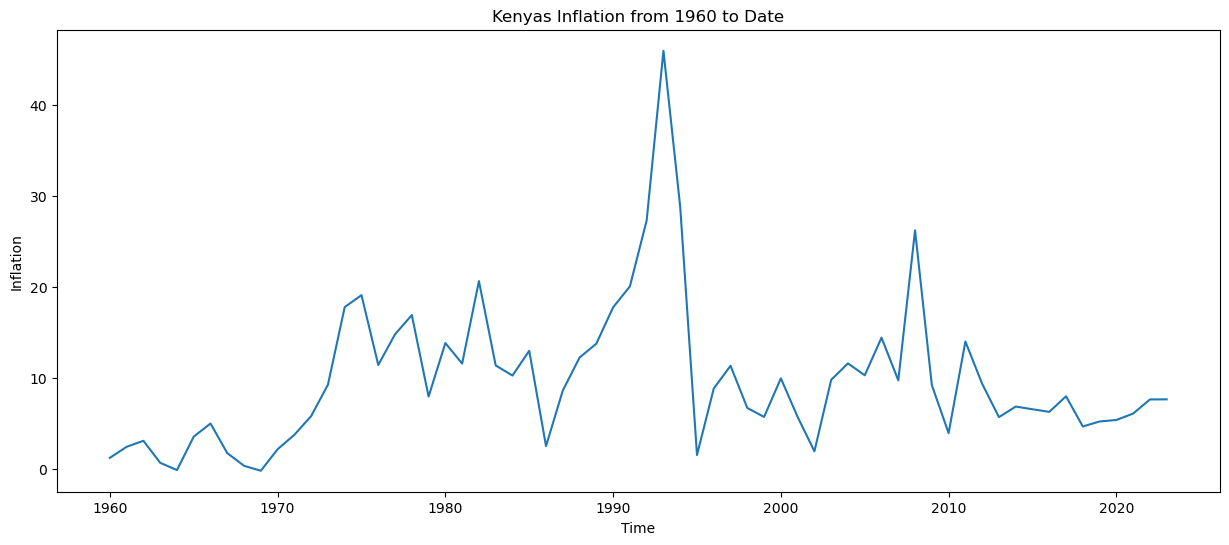

In [9]:
# A line plot of the inflation data
fig, ax= plt.subplots(figsize= (15,6))
df["Inflation"].plot(xlabel="Time", ylabel="Inflation", title= "Kenyas Inflation from 1960 to Date", ax=ax)
plt.show()

In [10]:
# Checking data information
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 64 entries, 1960 to 2023
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Inflation  64 non-null     float64
dtypes: float64(1)
memory usage: 1.0 KB


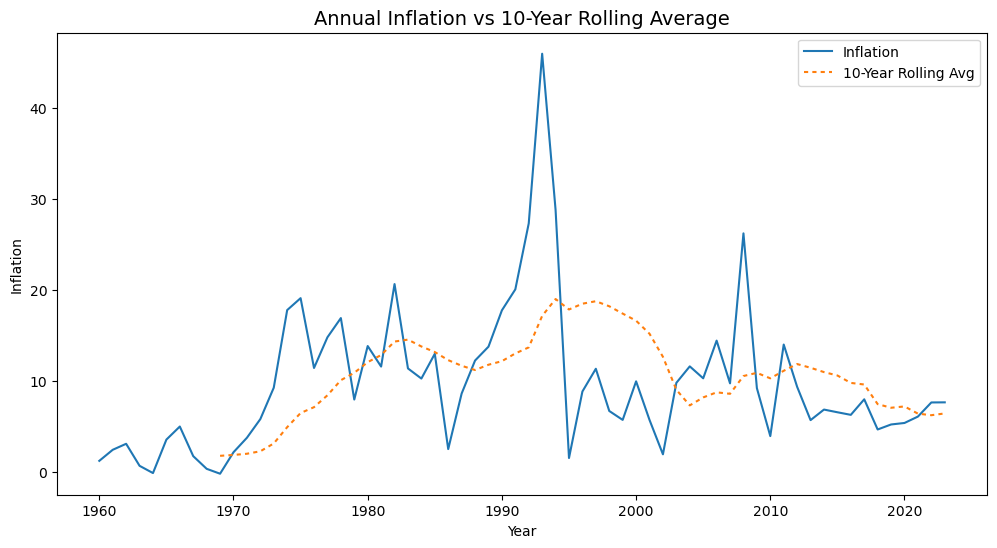

In [12]:
# Visualization 2: Rolling Average vs Annual Rates
plt.figure(figsize=(12, 6))
df['10-Year Rolling Avg'] = df['Inflation'].rolling(window=10).mean()
sns.lineplot(data= df[['Inflation', '10-Year Rolling Avg']], 
            dashes= {'Inflation': '', '10-Year Rolling Avg': (2, 2)},
            palette= ['#1f77b4', '#ff7f0e'])
plt.title('Annual Inflation vs 10-Year Rolling Average', size=14)
plt.ylabel('Inflation')
plt.show()

In [13]:
# creating a new column for shifted values
df["Inflation.L1"]= df["Inflation"].shift(1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64 entries, 1960 to 2023
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Inflation            64 non-null     float64
 1   10-Year Rolling Avg  55 non-null     float64
 2   Inflation.L1         63 non-null     float64
dtypes: float64(3)
memory usage: 2.0 KB


In [14]:
# Drop the resulting Null values
df.dropna(inplace=True)
df.head()

,Inflation,10-Year Rolling Avg,Inflation.L1
Year,,,
1969,-0.171501,1.796399,0.366712
1970,2.188527,1.890874,-0.171501
1971,3.780206,2.023194,2.188527
1972,5.831645,2.294608,3.780206
1973,9.281194,3.152960,5.831645


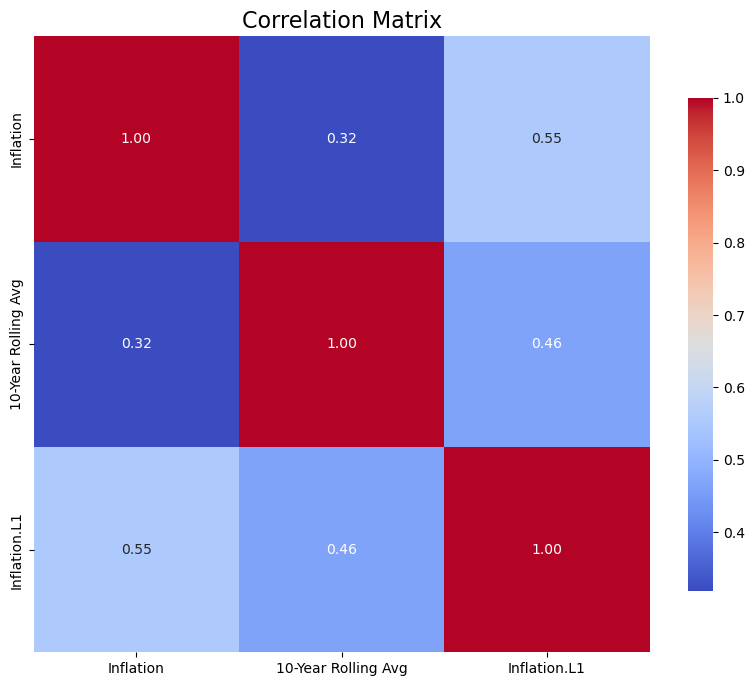

,Inflation,10-Year Rolling Avg,Inflation.L1
Inflation,1.000000,0.319096,0.554063
10-Year Rolling Avg,0.319096,1.000000,0.463624
Inflation.L1,0.554063,0.463624,1.000000


In [15]:
# Check for multicollinearity
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix", size=16)
plt.show()
# Check for multicollinearity using the correlation matrix
df.corr()

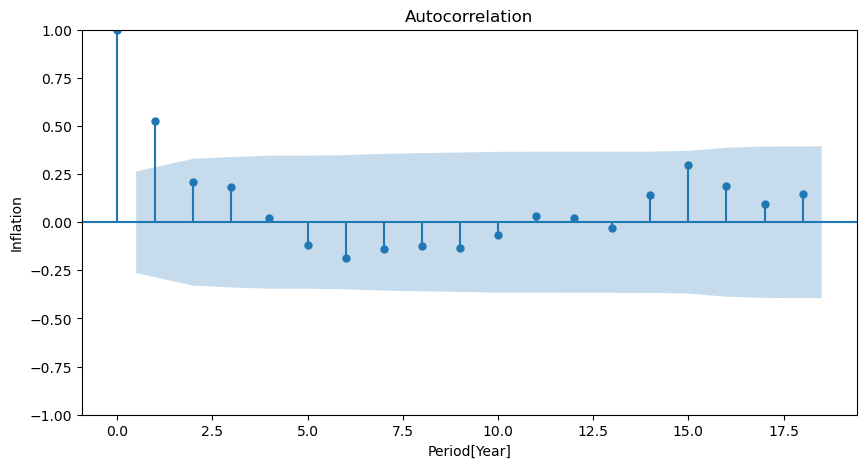

In [16]:
# Plotting ACF
fig, ax=plt.subplots(figsize=(10,5))
plot_acf(df["Inflation"], ax=ax)
plt.xlabel("Period[Year]")
plt.ylabel("Inflation");

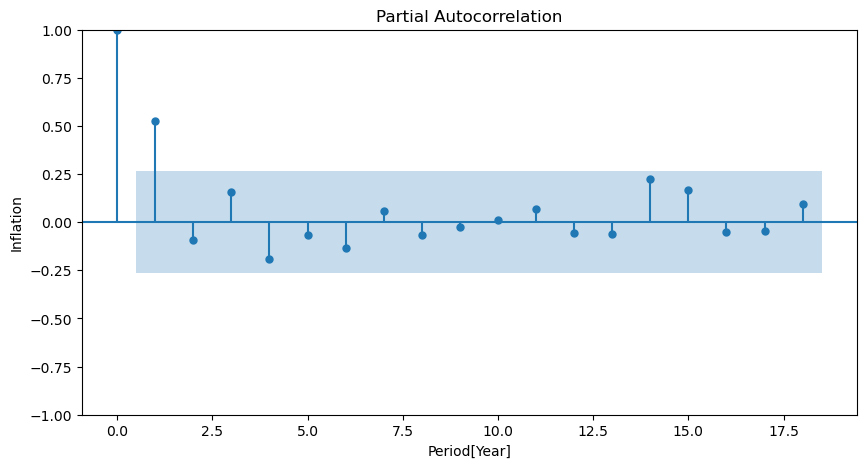

In [17]:
# Plotting PACF
fig, ax=plt.subplots(figsize=(10,5))
plot_pacf(df["Inflation"], ax=ax)
plt.xlabel("Period[Year]")
plt.ylabel("Inflation");

In [22]:
# Checking for stationarity using Augmented Dickey-Fuller test
output = adfuller(df["Inflation"])
print(f"\n statistic: {output[0].round(5)}, \n p-value: {output[1].round(5)}, \n critical values: {output[4]}, \n criterion: {output[5]}")


 statistic: -4.1042, 
 p-value: 0.00095, 
 critical values: {'1%': -3.55770911573439, '5%': -2.9167703434435808, '10%': -2.59622219478738}, 
 criterion: 293.7190930384573


In [23]:
# Performing the split into train and test sets 90/10
cutoff_test= int(len(df["Inflation"]) * .9)
y_train= df["Inflation"].iloc[:cutoff_test]
y_test= df["Inflation"].iloc[cutoff_test:]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (49,)
y_test shape: (6,)


In [24]:
# Calculate the mean and mean absolute error for the baseline model
y_train_mean= y_train.mean()
y_pred_baseline= [y_train_mean] * len(y_train)
mae_baseline= mean_absolute_error(y_train, y_pred_baseline)
print("y_train_mean:", round(y_train_mean, 4))
print("Baseline MAE:", round(mae_baseline, 4))

y_train_mean: 11.6584
Baseline MAE: 5.6646


In [25]:
# Calculating the p,d,q parameters using auto_arima
p_params= range(0, 5, 1)
q_params= range(0, 4, 1)
mae_matrix={}
for p in p_params:
    mae_matrix[p]= []
    for q in q_params:
        order= (p, 0, q)
        # start_time=time.time()
        model= ARIMA(y_train, order=order).fit()
        print(f"Trained ARIMA {order}")
        y_pred= model.predict()
        mae= mean_absolute_error(y_train, y_pred)
        mae_matrix[p].append(mae)
print()
print(mae_matrix)    

Trained ARIMA (0, 0, 0)
Trained ARIMA (0, 0, 1)
Trained ARIMA (0, 0, 2)
Trained ARIMA (0, 0, 3)
Trained ARIMA (1, 0, 0)
Trained ARIMA (1, 0, 1)
Trained ARIMA (1, 0, 2)
Trained ARIMA (1, 0, 3)
Trained ARIMA (2, 0, 0)
Trained ARIMA (2, 0, 1)
Trained ARIMA (2, 0, 2)
Trained ARIMA (2, 0, 3)
Trained ARIMA (3, 0, 0)
Trained ARIMA (3, 0, 1)
Trained ARIMA (3, 0, 2)
Trained ARIMA (3, 0, 3)
Trained ARIMA (4, 0, 0)
Trained ARIMA (4, 0, 1)
Trained ARIMA (4, 0, 2)
Trained ARIMA (4, 0, 3)

{0: [5.66463883153904, 4.936161702892001, 4.931300632744758, 4.677388823615828], 1: [5.018521412332137, 4.93788818085708, 4.903006548222323, 4.570553546267004], 2: [5.037597794354665, 4.779126337597356, 4.863557626562052, 4.683314732773345], 3: [4.870670596688357, 4.677683977707918, 4.673761209866156, 4.120647869955801], 4: [4.608651744835163, 4.579115626476533, 4.521560659488962, 4.185040676124935]}


In [26]:
# Combining the Mean absolute Error into a DataFrame
mae_df= pd.DataFrame(mae_matrix)
mae_df.round(4)

,0,1,2,3,4
0,5.6646,5.0185,5.0376,4.8707,4.6087
1,4.9362,4.9379,4.7791,4.6777,4.5791
2,4.9313,4.9030,4.8636,4.6738,4.5216
3,4.6774,4.5706,4.6833,4.1206,4.1850


In [27]:
#Getting the best order of (p,d,q)
auto_model = auto_arima(df["Inflation"], seasonal=False, trace=True)
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=377.242, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=444.881, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=378.396, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=403.701, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=375.219, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=398.201, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=379.055, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=377.217, Time=0.12 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=392.037, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=380.412, Time=0.09 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=378.848, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=372.072, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=371.017, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=369.140, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=386.8

In [28]:
#fitting the model
model_best_arima= ARIMA(df["Inflation"], order=(1, 0, 3))
output_arima= model_best_arima.fit()
output_arima

In [29]:
# Forecast 5 years
f_arima= output_arima.get_forecast(steps=5)
f_index = pd.date_range(start='2024', periods=5, freq='YS')

forecast_df = pd.DataFrame({
    'Year': f_index.year,
    'Inflation Rate (ARIMA)': f_arima.predicted_mean,
    'Lower CI (ARIMA)': f_arima.conf_int().iloc[:, 0],
    'Upper CI (ARIMA)': f_arima.conf_int().iloc[:, 1]
})



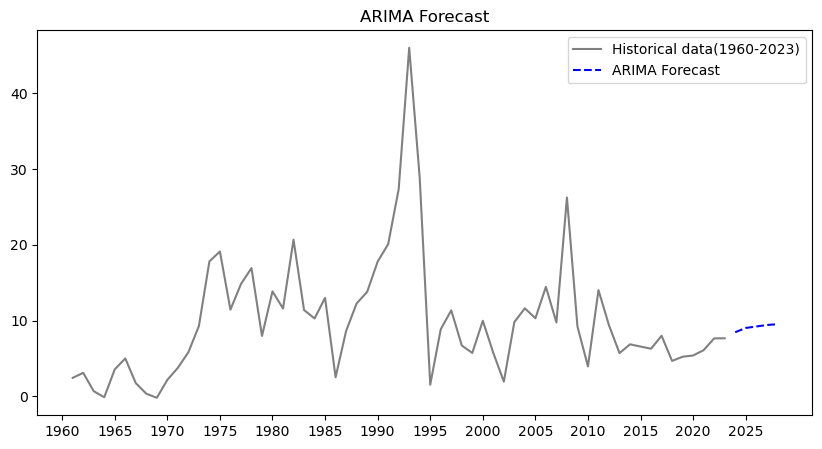

In [66]:
plt.figure(figsize=(10,5))
#Historical data
plt.plot(df.index, df["Inflation"], label= "Historical data(1960-2023)", color="gray")
plt.plot(forecast_df["Year"], forecast_df["Inflation Rate (ARIMA)"], label="ARIMA Forecast", color="blue", linestyle="dashed")
plt.xticks(range(1960, 2029, 5))
plt.legend()
plt.title("ARIMA Forecast")
plt.show()